# 0. Содержание

1. Библиотеки и настройки
2. Загрузка данных
3. Описание датасета
4. Анализ данных
    1. Бинарные признаки
    2. Числовые признаки
    3. Выбросы
    4. Категориальные признаки
5. Дилемма precision vs recall
    1. Accuracy
    2. Точность и полнота
6. Предобработка
    1. Кодирование категориальных переменных
    2. Oversampling. Максимизация полноты
    3. Выбросы
    4. Нормализация
    5. Feature Selection
7. Моделирование
    1. Логистическая регрессия
    2. Модели на основе деревьев
    3. Хайповые модели
8. Light GBM Classifier
9. Выводы
    1. Что касается сердца
    2. Что касается модели

# 1. Библиотеки и настройки

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pandas_profiling import ProfileReport
import seaborn as sns
from catboost import CatBoostClassifier
from imblearn.over_sampling import SMOTE
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier, IsolationForest
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, fbeta_score, roc_auc_score, \
    confusion_matrix
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearnex import patch_sklearn, unpatch_sklearn
from tqdm.notebook import tqdm
from xgboost import XGBClassifier

# import optuna
# optuna.logging.set_verbosity(optuna.logging.WARNING)

sns.set(
    palette="tab10",
    font_scale=1.2,
    rc={
        "figure.figsize": (9, 7),
        "axes.titlepad": 24,
        "axes.labelpad": 20,
        "axes.titlesize": 22,
        "figure.titlesize": 22,
        "figure.subplot.hspace": 0.3,
        "figure.subplot.wspace": 0.25
    })

RAND_STATE = 42

# 2. Загрузка данных

Датасет:
[Personal Key Indicators of Heart Disease
2020 annual CDC survey data of 400k adults related to their health status](https://www.kaggle.com/datasets/kamilpytlak/personal-key-indicators-of-heart-disease)

In [2]:
df = pd.read_csv("./heart_2020_cleaned.csv")
df.head()

,HeartDisease,BMI,Smoking,AlcoholDrinking,Stroke,PhysicalHealth,MentalHealth,DiffWalking,Sex,AgeCategory,Race,Diabetic,PhysicalActivity,GenHealth,SleepTime,Asthma,KidneyDisease,SkinCancer
0,No,16.60,Yes,No,No,3.0,30.0,No,Female,55-59,White,Yes,Yes,Very good,5.0,Yes,No,Yes
1,No,20.34,No,No,Yes,0.0,0.0,No,Female,80 or older,White,No,Yes,Very good,7.0,No,No,No
2,No,26.58,Yes,No,No,20.0,30.0,No,Male,65-69,White,Yes,Yes,Fair,8.0,Yes,No,No
3,No,24.21,No,No,No,0.0,0.0,No,Female,75-79,White,No,No,Good,6.0,No,No,Yes
4,No,23.71,No,No,No,28.0,0.0,Yes,Female,40-44,White,No,Yes,Very good,8.0,No,No,No


<a name="dataset-description"></a>

# 3. Описание датасета

Датасет содержит информацию о более 300 000 опрошенных респондентов. Опрос проводился с помощью телефонных звонков. Вопросы задавались с целью определения факторов, которые могут влиять на здоровье сердца. Таким образом, можно постараться выявить корреляцию между образом жизни, состоянием здоровья респондента и наличием сердечных заболеваний. Данные на 2020 год, и по идее они должны обновляться каждый год, но я не нашёл актуальную версию на Kaggle, так что nevermind.

Признаки:
1. `HeartDisease` **\[bool, target\]** - респонденты, которые когда-либо сообщали о наличии ишемической болезни сердца (ИБС) или инфаркта миокарда (ИМ)
2. `BMI` **\[continuous, float\]** - индекс массы тела
3. `Smoking` **\[bool\]** - выкурил ли респондент за всю свою жизнь не менее 100 сигарет? (Примечание: 5 пачек = 100 сигарет)
4. `AlcoholDrinking` **\[bool\]** - сильно пьющие (взрослые мужчины, выпивающие более 14 напитков в неделю, и взрослые женщины, выпивающие более 7 напитков в неделю)
5. `Stroke` **\[bool\]** - у вас был инсульт?
6. `PhysicalHealth` **\[categorical, int\]** - в течение скольких дней за последние 30 дней вас беспокоило состояние вашего физического здоровья (физические болезни, травмы и т.п.)?
7. `MentalHealth` **\[categorical, int\]** - в течение скольких дней за последние 30 дней ваше психическое состояние было плохим?
8. `DiffWalking` **\[bool\]** - испытываете ли вы серьезные трудности при ходьбе или подъеме по лестнице?
9. `Sex` **\[bool\]**- мужчина/женщина
10. `AgeCategory` **\[categorical\]** - возрастная категория (из 14 категорий)
11. `Race` **\[categorical\]** - раса
12. `Diabetic` **\[bool\]** - вы когда-нибудь болели диабетом?
13. `PhysicalActivity` **\[bool\]** - респондент в течение последних 30 дней занимался физической активностью или упражнениями помимо своей обычной работы
14. `GenHealth` **\[categorical, ordered\]** - могли бы вы сказать, что в целом ваше здоровье... (очень хорошее, хорошее, нормальное и т.д.)
15. `SleepTime` **\[continuous, float\]** - сколько часов в среднем вы спите в течение 24 часов?
16. `Asthma` **\[bool\]** - есть ли у вас астма?
17. `KidneyDisease` **\[bool\]** - есть ли у вас заболевание почек?
18. `SkinCancer` **\[bool\]** - есть ли у вас рак кожи?

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 319795 entries, 0 to 319794
Data columns (total 18 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   HeartDisease      319795 non-null  object 
 1   BMI               319795 non-null  float64
 2   Smoking           319795 non-null  object 
 3   AlcoholDrinking   319795 non-null  object 
 4   Stroke            319795 non-null  object 
 5   PhysicalHealth    319795 non-null  float64
 6   MentalHealth      319795 non-null  float64
 7   DiffWalking       319795 non-null  object 
 8   Sex               319795 non-null  object 
 9   AgeCategory       319795 non-null  object 
 10  Race              319795 non-null  object 
 11  Diabetic          319795 non-null  object 
 12  PhysicalActivity  319795 non-null  object 
 13  GenHealth         319795 non-null  object 
 14  SleepTime         319795 non-null  float64
 15  Asthma            319795 non-null  object 
 16  KidneyDisease     31

In [4]:
df.nunique()

HeartDisease           2
BMI                 3604
Smoking                2
AlcoholDrinking        2
Stroke                 2
PhysicalHealth        31
MentalHealth          31
DiffWalking            2
Sex                    2
AgeCategory           13
Race                   6
Diabetic               4
PhysicalActivity       2
GenHealth              5
SleepTime             24
Asthma                 2
KidneyDisease          2
SkinCancer             2
dtype: int64

Датасет содержит 4 числовых признака. Остальные 14 признаков либо бинарные, либо категориальные-строковые. Null-значения отсутствуют. Можно заметить, что признак Diabetic оказался небинарным. Посмотрим на его уникальные значения

In [5]:
df["Diabetic"].value_counts()

No                         269653
Yes                         40802
No, borderline diabetes      6781
Yes (during pregnancy)       2559
Name: Diabetic, dtype: int64

В принципе последние два варианта это те же Yes и No с некоторыми условиями. Эти объекты исключительные, их количество мало, поэтому можно просто на Yes и No заменить позже, чтобы не париться с кодированием

# 4. Анализ данных


С этого можно было начать, но обычно лучше сначала немного руками потрогать датасет, а потом профилирование делать. Давайте посмотрим на собранную Пандасом информацию

In [6]:
profile = ProfileReport(
    df,
    minimal=True,
    correlations={
        "auto": {"calculate": True},
        "pearson": {"calculate": True},
        "phi_k": {"calculate": True},
        "cramers": {"calculate": True},
    },
    interactions={
        "targets": ["HeartDisease"]
    },
    html={
        "style": {"theme": "flatly"}
    }
)
profile.to_file("heart_disease_report.html")
profile.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

### Если не отображается профилирование

Гитхаб не рендерит HTML в превью файлов. Репорт можно посмотреть по [этой ссылке [github pages]](https://korostast.github.io/heart-disease-prediction)

**Некоторые выводы:**
1. Имеем дело с несбалансированными данными. Шесть несбалансированных признаков, в том числе и таргет (HeartDisease). Вспомним этот факт при оценке качестве модели
2. Крайне сильно коррелирующих величин нет
3. BMI имеет длинный положительный хвост нормального распределения при среднем значении равным 28. Вероятно, тут мы найдём немало выбросов
4. Две первые моды PhysicalHealth и MentalHealth - 0 и 30. Вероятно значения между ними особого смысла не несут. Особенно много нулей (от 64% до 71%). Эти признаки можно бинаризировать: превратить значения в 0 или 1 (0 дней или не 0 дней с жалобами на здоровье)
5. SleepTime лежит в основном между 5 и 10. Выше 12 вообще смысла не имеет, кто столько спит? Надо проверить на выбросы
6. Таргет имеет наибольшую корреляцию (я рассматривал > 0.1 по модулю) с 8 признаками: PhysicalHealth, Smoking, Stroke, DiffWalking, AgeCategory, Diabetic, GenHealth и KidneyDisease

Сейчас посмотрим внимательнее на обозначенные пункты

Посмотрим на распределение таргета (наличие сердечного заболевания). Как упоминалось ранее, у нас данные несбалансированы: болезнь сердца имеют 9% респондентов

No     0.91
Yes    0.09
Name: HeartDisease, dtype: float64

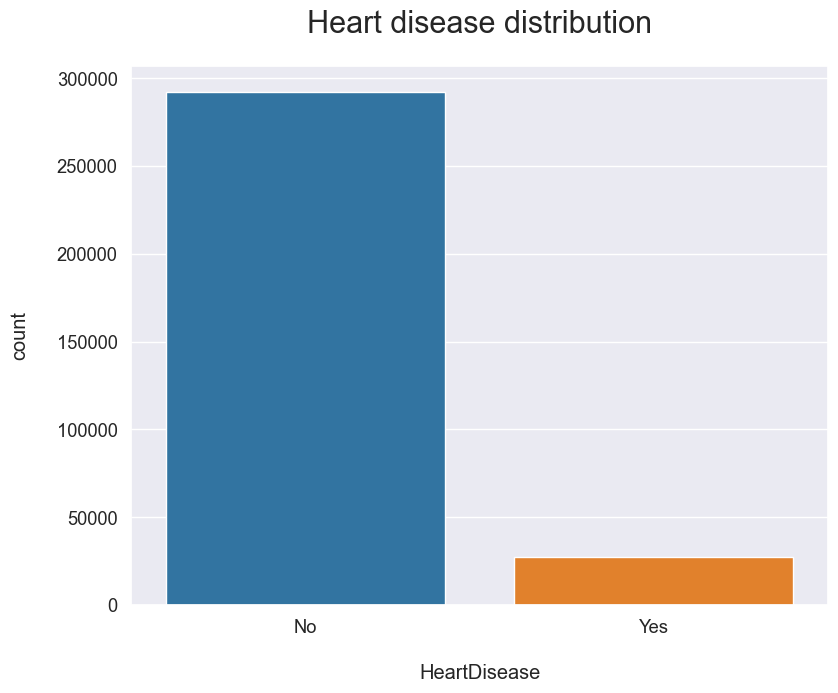

In [7]:
p = sns.countplot(df, x="HeartDisease")
_ = p.set_title("Heart disease distribution")
df["HeartDisease"].value_counts(normalize=True).round(2)

## 4.1. Бинарные признаки

Посмотрим на зависимости таргета от бинарных признаков

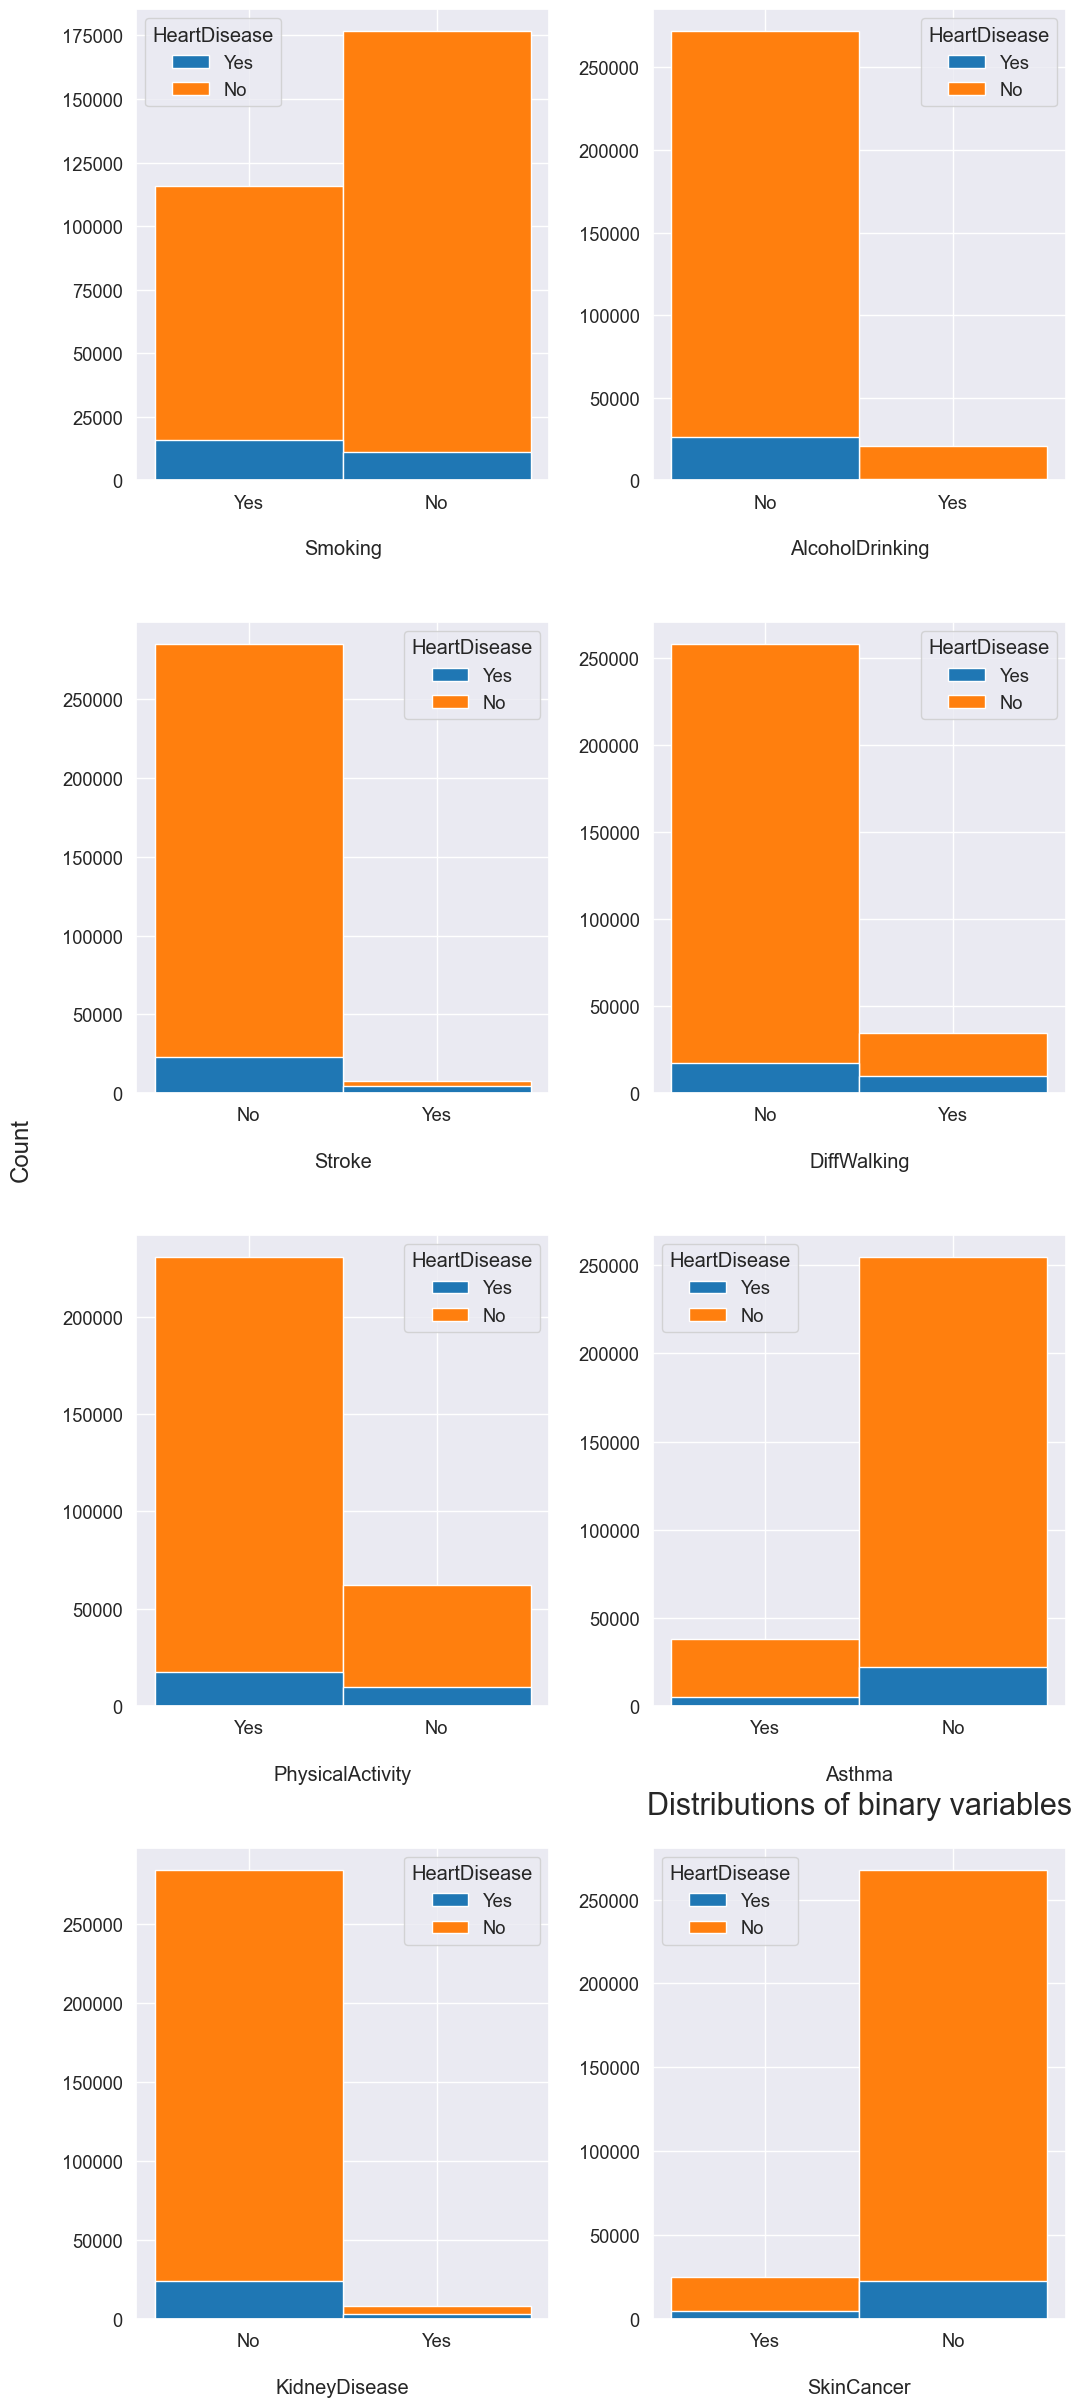

In [8]:
fig, axes = plt.subplots(4, 2, figsize=(12, 30))
fig.supylabel("Count")

hist_kwargs = dict(data=df, hue="HeartDisease", alpha=1, hue_order=["Yes", "No"])
sns.histplot(ax=axes[0, 0], x="Smoking", **hist_kwargs)
sns.histplot(ax=axes[0, 1], x="AlcoholDrinking", **hist_kwargs)
sns.histplot(ax=axes[1, 0], x="Stroke", **hist_kwargs)
sns.histplot(ax=axes[1, 1], x="DiffWalking", **hist_kwargs)
sns.histplot(ax=axes[2, 0], x="PhysicalActivity", **hist_kwargs)
sns.histplot(ax=axes[2, 1], x="Asthma", **hist_kwargs)
sns.histplot(ax=axes[3, 0], x="KidneyDisease", **hist_kwargs)
sns.histplot(ax=axes[3, 1], x="SkinCancer", **hist_kwargs)
plt.title("Distributions of binary variables")

for i in range(4):
    for j in range(2):
        axes[i, j].set_ylabel("")

**Некоторые выводы:**
1. Курящий человек имеет незначительно больший шанс получить сердечное заболевание
2. Алкоголизм кажется практически не влияет на шанс сердечного заболевания? Вероятно, этот признак не несёт много полезной информации
3. Если у человека однажды был инсульт, то с большой вероятностью (грубо говоря, 36%) у него имеются проблемы с сердцем. Логично
4. Так же немало важным фактором является трудности при ходьбе и подъёме по лестницам
5. У людей без физической активности немного выше шанс заболевания
6. Кажется, астма не является фактором наличия сердечного заболевания?
7. Если у человек есть проблемы с почками, то с шансом ~30% у него есть проблемы с сердцем
8. Наличие рака кожи говорит о ~17% наличия проблем с сердцем. Не слишком выраженная закономерность

Позже, на этапе Feature Selection (в предобработке данных), мы вернёмся к рассмотрению полезных и бесполезных признаков

Ради интереса посмотрим, какой процент людей имеют сердечное заболевание, если они курящие, у них был инсульт, есть проблемы с лестницами и имеют почечные заболевания (61%):

In [9]:
df_bad = df[
    (df.Smoking == "Yes") &
    (df.Stroke == "Yes") &
    (df.DiffWalking == "Yes") &
    (df.KidneyDisease == "Yes")
    ]["HeartDisease"]
print(f"Number of people: {len(df_bad)}")
df_bad.value_counts(normalize=True).round(2)

Number of people: 569


Yes    0.61
No     0.39
Name: HeartDisease, dtype: float64

Посмотрим на корреляцию сердечных заболеваний и пола

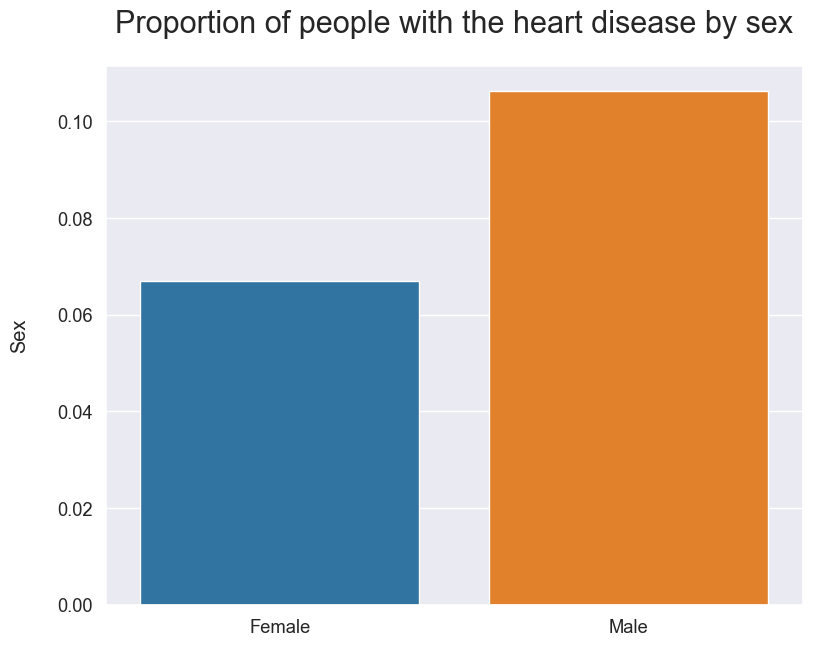

In [10]:
sex_has_disease_part = np.divide(
    df[df["HeartDisease"] == "Yes"]["Sex"].value_counts().sort_index(),
    df["Sex"].value_counts().sort_index()
)
p = sns.barplot(x=sex_has_disease_part.index, y=sex_has_disease_part)
_ = p.set_title("Proportion of people with the heart disease by sex")

Из всех женщин в датасете 7% имеют заболевание сердца, из всех мужчин - 11%


## 4.2. Числовые признаки

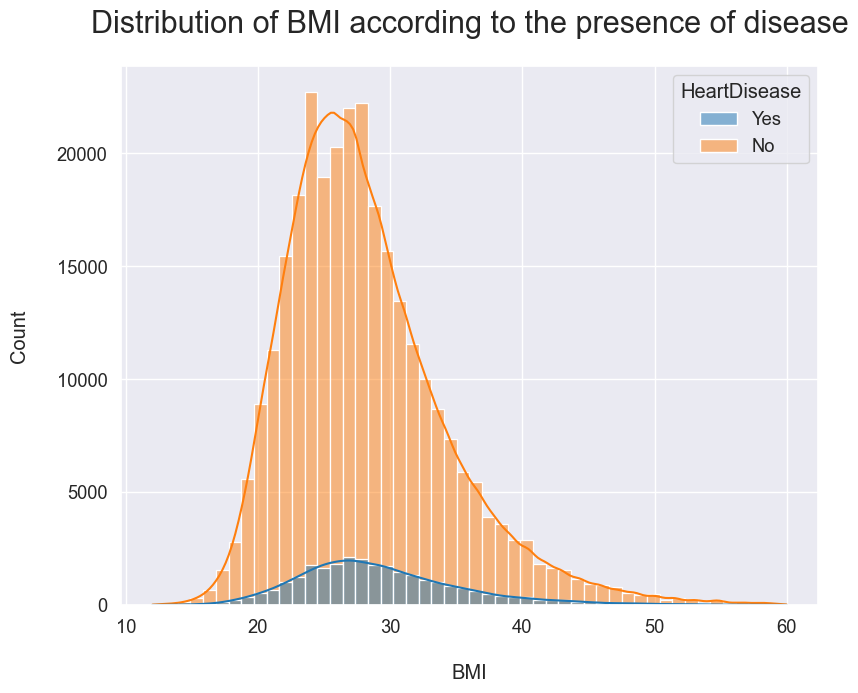

In [11]:
p = sns.histplot(df[df["BMI"] < 60], x="BMI", hue="HeartDisease", kde=True, bins=50, hue_order=["Yes", "No"])
_ = p.set_title("Distribution of BMI according to the presence of disease")

Распределения похожи на нормальные, но есть хвост в положительную сторону. Среднее BMI людей, имеющих сердечное заболевание, и среднее BMI, не имеющих заболевание, примерно равны

Далее посмотрим на физическое и ментальное здоровье респондентов

In [12]:
df["PhysicalHealth"].value_counts(normalize=True).round(3)

0.0     0.709
30.0    0.061
2.0     0.047
1.0     0.033
3.0     0.027
5.0     0.024
10.0    0.017
15.0    0.016
7.0     0.014
4.0     0.014
20.0    0.010
14.0    0.009
6.0     0.004
25.0    0.004
8.0     0.003
21.0    0.002
12.0    0.002
28.0    0.001
29.0    0.001
9.0     0.001
18.0    0.001
16.0    0.000
27.0    0.000
17.0    0.000
13.0    0.000
22.0    0.000
11.0    0.000
24.0    0.000
26.0    0.000
23.0    0.000
19.0    0.000
Name: PhysicalHealth, dtype: float64

Судя по распределению чисел (визуализировать графиком бесполезно), большинство на вопрос о количестве дней, в которые респондент испытывал проблемы с физическим здоровьем в последние 30 дней, отвечало либо 0 дней, либо 30 дней. Имеет смысл, ибо считать дни, в которые у тебя болит нога, тупо. И скорее всего, имеет смысл заменить 0 дней на "Не имеет жалоб на физ здоровье", а больше 0 дней - "Имеет жалобы"

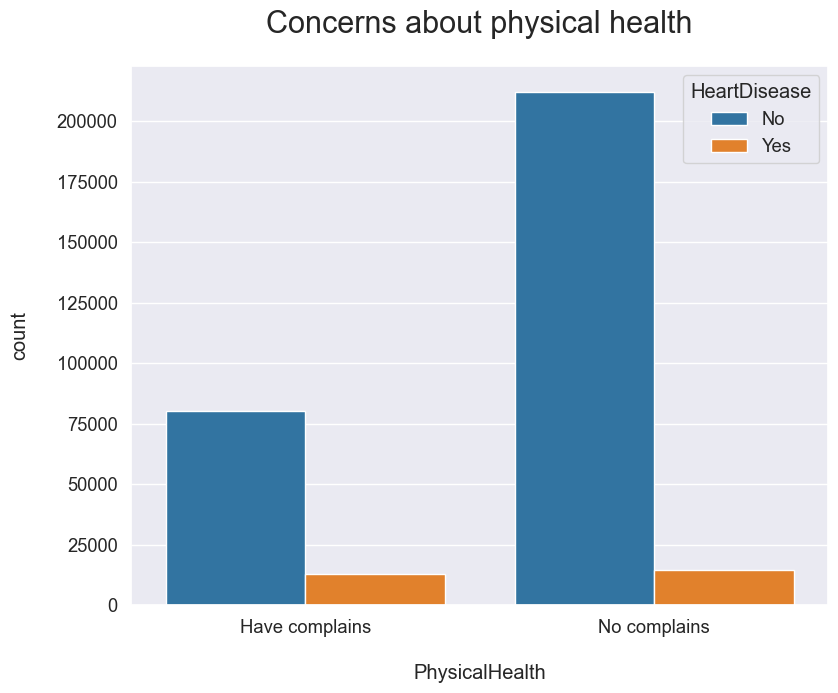

In [13]:
df_copy = df.copy()
df_copy["PhysicalHealth"] = (df_copy["PhysicalHealth"] > 0).astype(int)
df_copy.replace({0: "No complains", 1: "Have complains"}, inplace=True)
p = sns.countplot(df_copy, x="PhysicalHealth", hue="HeartDisease")
_ = p.set_title("Concerns about physical health")

Судя по соотношению столбцов, если у человека были физические траблы в последние 30 дней, то вероятно это связано с сердцем. Имеет смысл

Теперь посмотрим на ментальное здоровье:

In [14]:
df["MentalHealth"].value_counts(normalize=True).round(3)

0.0     0.642
30.0    0.054
2.0     0.052
5.0     0.044
10.0    0.033
3.0     0.033
15.0    0.031
1.0     0.029
7.0     0.017
20.0    0.017
4.0     0.017
14.0    0.006
25.0    0.006
6.0     0.005
8.0     0.003
12.0    0.002
28.0    0.002
21.0    0.001
29.0    0.001
18.0    0.001
9.0     0.001
16.0    0.000
17.0    0.000
27.0    0.000
13.0    0.000
22.0    0.000
11.0    0.000
23.0    0.000
24.0    0.000
26.0    0.000
19.0    0.000
Name: MentalHealth, dtype: float64

То же, что и с физ здоровьем: заменим 0 и больше 0

Построим histplot, ибо так будет проще вывод сделать

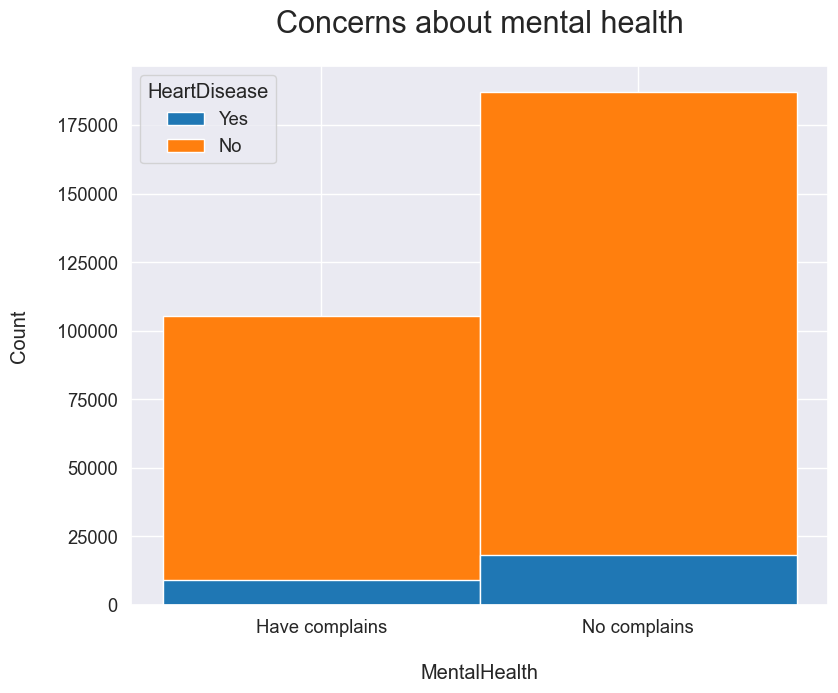

In [15]:
df_copy = df.copy()
df_copy["MentalHealth"] = (df_copy["MentalHealth"] > 0).astype(int)
df_copy.replace({0: "No complains", 1: "Have complains"}, inplace=True)
p = sns.histplot(df_copy, x="MentalHealth", hue="HeartDisease", alpha=1, hue_order=["Yes", "No"])
_ = p.set_title("Concerns about mental health")

Судя по соотношению столбцов, если у человека были ментальные траблы в последние 30 дней, то... это не связано с сердцем? Явной корреляции нет. Может быть признак будет фиктивным?

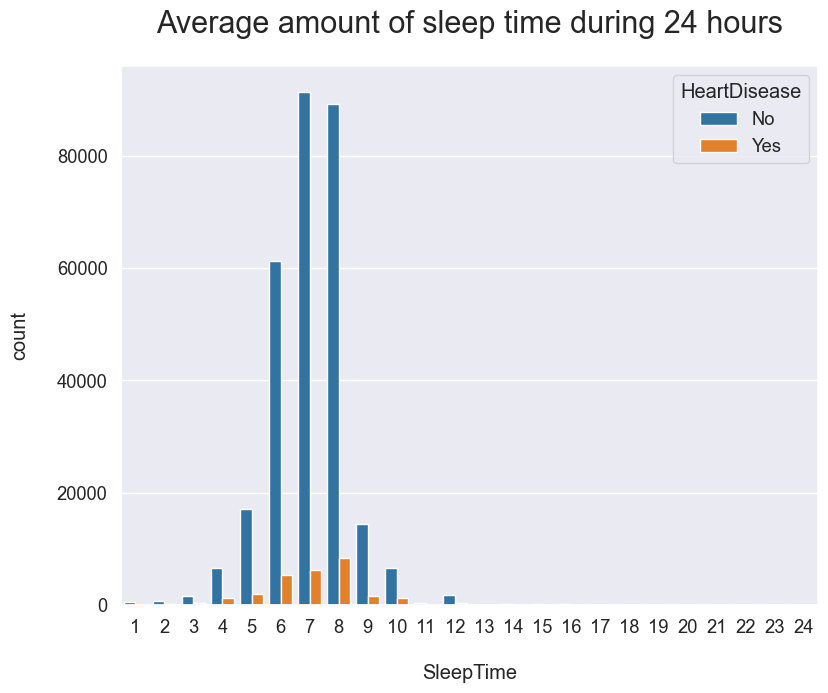

In [16]:
df_copy = df.copy()
df_copy["SleepTime"] = df_copy["SleepTime"].astype(int)
p = sns.countplot(df_copy, x="SleepTime", hue="HeartDisease")
_ = p.set_title("Average amount of sleep time during 24 hours")

В целом от количества сна таргет особо не зависит. Люди в основном спят по 5-9 часов. Кто спит больше или меньше?

In [17]:
n = len(df[(df["SleepTime"] > 12) & (df["MentalHealth"] > 0)]) / (df["SleepTime"] > 12).sum()
print(f"Number of people with mental awareness and sleep time more than 12 hours: {round(n * 100, 1)}%")

n = len(df[(df["SleepTime"] < 6) & (df["MentalHealth"] > 0)]) / (df["SleepTime"] < 6).sum()
print(f"Number of people with mental awareness and sleep time less than 6 hours: {round(n * 100, 1)}%")

Number of people with mental awareness and sleep time more than 12 hours: 49.0%
Number of people with mental awareness and sleep time less than 6 hours: 52.7%


Стоит ли доверять людям, которые спят по 24 часа в день?))

Ситуация c выбросами в числовых признаках такова:

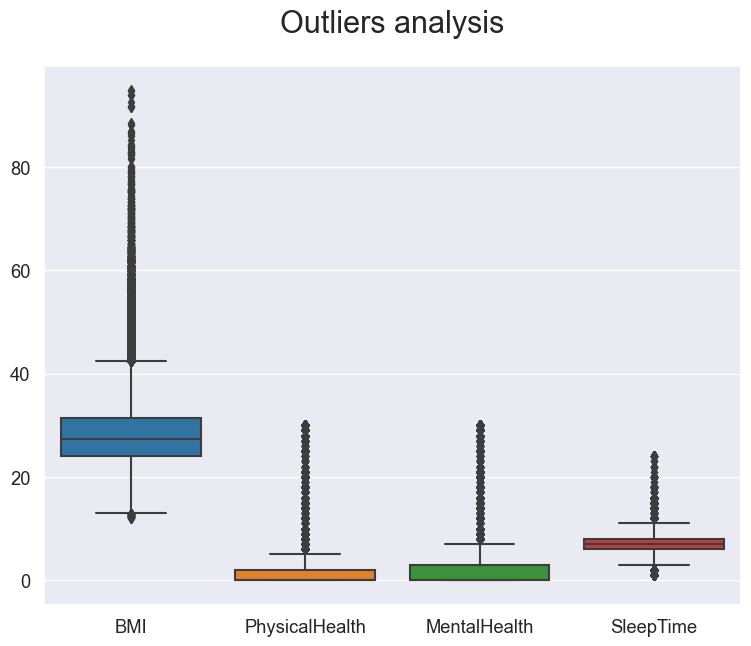

In [18]:
p = sns.boxplot(df)
_ = p.set_title("Outliers analysis")

В каждом из числовом признаке имеется немало выбросов. Особо много их в BMI

На этапе предобработки мы вычислим общее количество выбросов во всех данных некоторым методом машинного обучения и обработаем их

## 4.3. Категориальные признаки

Посмотрим на оценку респондентов своему здоровью

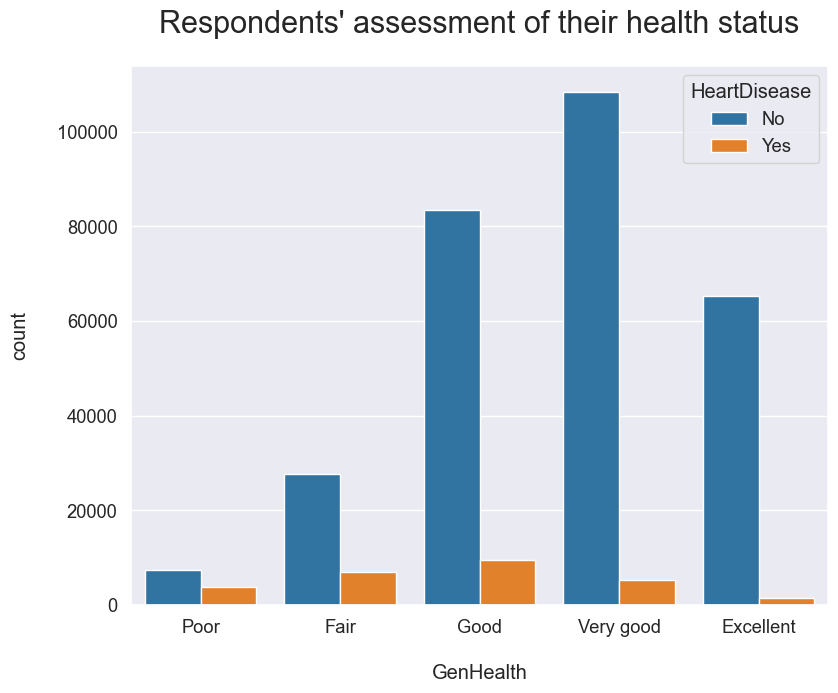

In [19]:
p = sns.countplot(df, x="GenHealth", hue="HeartDisease", order=["Poor", "Fair", "Good", "Very good", "Excellent"])
_ = p.set_title("Respondents' assessment of their health status")

In [20]:
df_temp = df.copy()
df_temp["GenHealth"] = df_temp["GenHealth"].replace({"Poor": 0, "Fair": 1, "Good": 2, "Very good": 3, "Excellent": 4})
print("Replaced 'Poor' with 0 and 'Excellent' with 4\nGenHealth mean:")
df_temp.groupby("HeartDisease").mean()["GenHealth"].round(2)

Replaced 'Poor' with 0 and 'Excellent' with 4
GenHealth mean:


HeartDisease
No     2.67
Yes    1.77
Name: GenHealth, dtype: float64

В среднем, люди имеющие сердечное заболевание чувствуют себя хуже. Логично

Что касается расы:

In [21]:
df.groupby("Race")["HeartDisease"].value_counts(normalize=True)

Race                            HeartDisease
American Indian/Alaskan Native  No              0.895809
                                Yes             0.104191
Asian                           No              0.967030
                                Yes             0.032970
Black                           No              0.924626
                                Yes             0.075374
Hispanic                        No              0.947424
                                Yes             0.052576
Other                           No              0.918924
                                Yes             0.081076
White                           No              0.908214
                                Yes             0.091786
Name: HeartDisease, dtype: float64

Чаще всего болезнь сердца имеют American Indian/Alaskan Native, реже всех - Asian

Наконец, посмотрим на людей с диабетом:

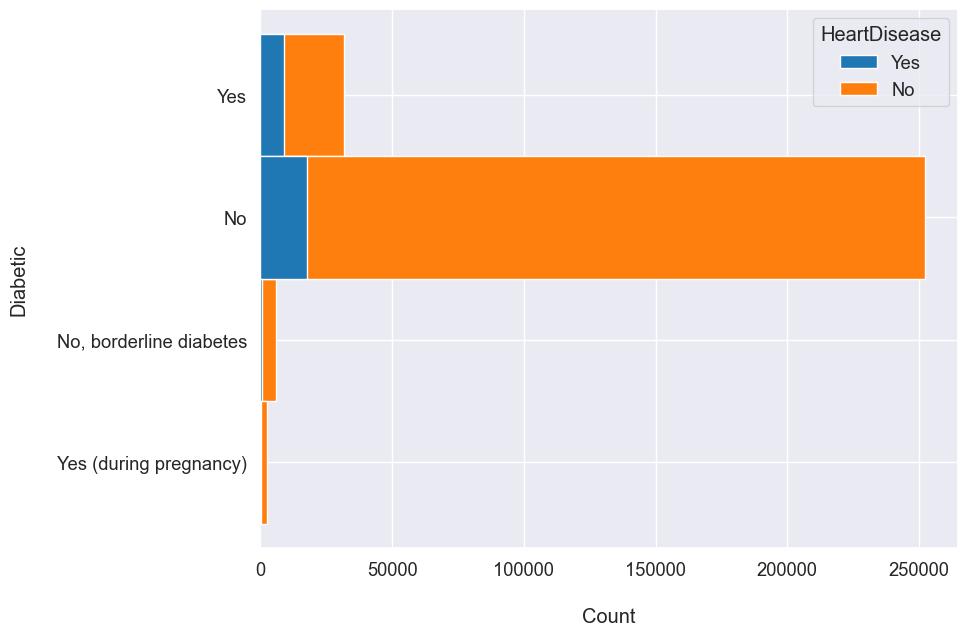

In [22]:
p = sns.histplot(df_copy, y="Diabetic", hue="HeartDisease", alpha=1, hue_order=["Yes", "No"])

Видимо, диабет влияет на работу сердца, ибо немалая доля людей с диабетом так же имеет проблемы с сердцем


# 5. Дилемма precision vs recall

## 5.1. Accuracy

Метрика accuracy нерелевантна в нашем случае из-за несбалансированности данных. В нашем случае 91% респондентов не имеют проблем с сердцем. Если модель будет всегда выдавать ответ _'проблем нет'_, то мы получим `accuracy = 0.91`. Казалось бы, высокое качество, но нет, ведь модель совершенно бесполезна. Перед тем, как оценивать качество, стоит сбалансировать тренировочные данные.

## 5.2. Точность и полнота

Перед тем, как производить обработку данных, стоит определиться, чего мы хотим от нашей будущей модели, на какие метрики мы будем опираться в первую очередь. Так как речь идёт о здоровье пациентов, то нам важно не пропускать наблюдения с возможными проблемами сердца. Даже если человек не был болен, но мы его полечили, это лучше, чем если бы он был болен, а мы его отпустили со смертельной болезнью. В данном случае, нужно уменьшать ошибку 2-ого рода, то есть минимизировать False Negative (ложно негативные ответы). Таким образом мы увеличим полноту:
$$
recall = \frac{\sum TP}{\sum TP + FN}
$$

Таким образом, точность важна в меньшей степени. Если мы приоритезируем точность, то будем тратить меньше средств на лечение пациентов. Хотя будем честны, модель ничего не будет решать за врачей, она может только помогать в предварительном анализе данных.

Overall, давайте максимизировать полноту, но не зануляя точность

![https://miro.medium.com/max/1400/1*7ukchzv8sK9hzKdpfYW6dQ.png](https://miro.medium.com/max/1400/1*7ukchzv8sK9hzKdpfYW6dQ.png)

# 6. Предобработка

## 6.1. Кодирование категориальных переменных

Заранее заменим бинарные признаки, которые представляют собой строки, в числа. Также заменим с помощью `label encoding` признак `GenHealth`. И бинаризуем `PhysicalHealth` и `MentalHealth`

In [23]:
df.replace({"No, borderline diabetes": "No", "Yes (during pregnancy)": "Yes"}, inplace=True)
df.replace({"Poor": 0, "Fair": 1, "Good": 2, "Very good": 3, "Excellent": 4}, inplace=True)
df["PhysicalHealth"] = (df["PhysicalHealth"] > 0).astype(int)
df["MentalHealth"] = (df["MentalHealth"] > 0).astype(int)

Применим `one-hot encoding` к остальным категориальным признакам. На всякий случай выкинем по одной категории у каждого признака, чтобы не было линейной зависимости между признаками

In [24]:
df = pd.get_dummies(df, drop_first=True)

И разделим датасет на тренировочную выборку и тестовую

In [25]:
y = df.pop("HeartDisease_Yes")

In [26]:
X_train, X_test, y_train, y_test = train_test_split(df, y, test_size=0.3, random_state=RAND_STATE)
X_train.head()

,BMI,PhysicalHealth,MentalHealth,GenHealth,SleepTime,Smoking_Yes,AlcoholDrinking_Yes,Stroke_Yes,DiffWalking_Yes,Sex_Male,...,Race_Asian,Race_Black,Race_Hispanic,Race_Other,Race_White,Diabetic_Yes,PhysicalActivity_Yes,Asthma_Yes,KidneyDisease_Yes,SkinCancer_Yes
303145,20.51,1,0,4,8.0,0,0,0,0,0,...,0,0,0,0,1,0,1,0,0,0
61634,30.82,0,0,3,7.0,0,0,0,0,0,...,0,0,0,1,0,1,1,0,1,0
117690,33.91,0,0,2,6.0,0,0,0,0,1,...,0,0,0,0,1,1,1,0,0,0
132104,21.59,0,0,3,8.0,1,0,0,0,1,...,0,0,0,0,1,0,1,0,0,0
262165,25.75,0,0,3,7.0,0,0,0,0,0,...,0,0,0,0,1,0,1,1,0,0


## 6.2. Oversampling. Максимизация полноты

У нас крайне несбалансированные данные. Чтобы не было проблем с обучением и подсчётом метрик (как минимум accuracy будет невалидной метрикой), давайте сбалансируем данные методом `SMOTE`. Этот метод выполняет аугментацию данных, создавая новые случайные наблюдения, похожие на своих соседей.

Особенностью этого метода так же является увеличение **полноты** за счёт **точности**. Как обсуждалось ранее, мы хотим допускать меньше ошибок второго рода.

In [27]:
X_train, y_train = SMOTE().fit_resample(X_train, y_train)
y_train.value_counts()

0    204773
1    204773
Name: HeartDisease_Yes, dtype: int64

## 6.3. Выбросы

Посчитаем долю выбросов в датасете с помощью изолирующего леса:

In [28]:
%%time
outliers_detector = IsolationForest(n_estimators=500, random_state=RAND_STATE).fit(df)
outliers_analysis = pd.DataFrame(outliers_detector.predict(df)).replace({-1: "Anomaly", 1: "Normal"})

pd.concat(
    [
        outliers_analysis.value_counts().rename("Count"),
        outliers_analysis.value_counts(normalize=True).rename("Proportion").round(2)
    ],
    axis=1
)

CPU times: total: 1min 28s
Wall time: 1min 28s


,Count,Proportion
0,,
Normal,286718,0.9
Anomaly,33077,0.1


Лес обнаружил по крайней мере 10% аномальных наблюдений. На самом деле, это не означает, что эти наблюдения мусорные. Вероятно, они отражают исключительных респондентов. Но не факт, так же возможно, что некоторые респонденты отвечали на вопросы как попало.

Применим тот же подход с изолирующим лесом и уберём выбросы из тренировочных данных

In [29]:
clf = IsolationForest(n_estimators=500, random_state=RAND_STATE)
clf.fit(X_train)
pred = clf.predict(X_train)
X_train = X_train.loc[pred != -1]
y_train = y_train.loc[pred != -1]
print(f"Number of outliers: {(pred == -1).sum()}")

Number of outliers: 36059


## 6.4. Нормализация

Стандартизируем данные

In [30]:
scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns, index=X_train.index)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns, index=X_test.index)
X_train.head()

,BMI,PhysicalHealth,MentalHealth,GenHealth,SleepTime,Smoking_Yes,AlcoholDrinking_Yes,Stroke_Yes,DiffWalking_Yes,Sex_Male,...,Race_Asian,Race_Black,Race_Hispanic,Race_Other,Race_White,Diabetic_Yes,PhysicalActivity_Yes,Asthma_Yes,KidneyDisease_Yes,SkinCancer_Yes
0,-1.296111,1.511485,-0.628116,1.572077,0.579171,-0.910951,-0.189082,-0.181318,-0.45175,-1.019869,...,-0.115121,-0.198439,-0.227844,-0.122051,0.459454,-0.422639,0.636317,-0.306948,-0.153385,-0.321733
2,0.866227,-0.661601,-0.628116,-0.215813,-0.766884,-0.910951,-0.189082,-0.181318,-0.45175,0.980518,...,-0.115121,-0.198439,-0.227844,-0.122051,0.459454,2.366085,0.636317,-0.306948,-0.153385,-0.321733
3,-1.121833,-0.661601,-0.628116,0.678132,0.579171,1.097754,-0.189082,-0.181318,-0.45175,0.980518,...,-0.115121,-0.198439,-0.227844,-0.122051,0.459454,-0.422639,0.636317,-0.306948,-0.153385,-0.321733
4,-0.450540,-0.661601,-0.628116,0.678132,-0.093857,-0.910951,-0.189082,-0.181318,-0.45175,-1.019869,...,-0.115121,-0.198439,-0.227844,-0.122051,0.459454,-0.422639,0.636317,3.257877,-0.153385,-0.321733
5,1.414880,-0.661601,-0.628116,0.678132,0.579171,1.097754,-0.189082,-0.181318,-0.45175,0.980518,...,-0.115121,-0.198439,-0.227844,-0.122051,0.459454,-0.422639,-1.571543,-0.306948,-0.153385,-0.321733


## 6.5. Feature Selection

На этапе анализа данных мы заметили, что некоторые признаки слабо коррелируют с таргетом. Посчитаем важность признаков на основе ANOVA F-value. Мы сравниваем вариации между признаками с вариациями внутри этих признаков. Если вариации равны, то признак не влияет на ответ

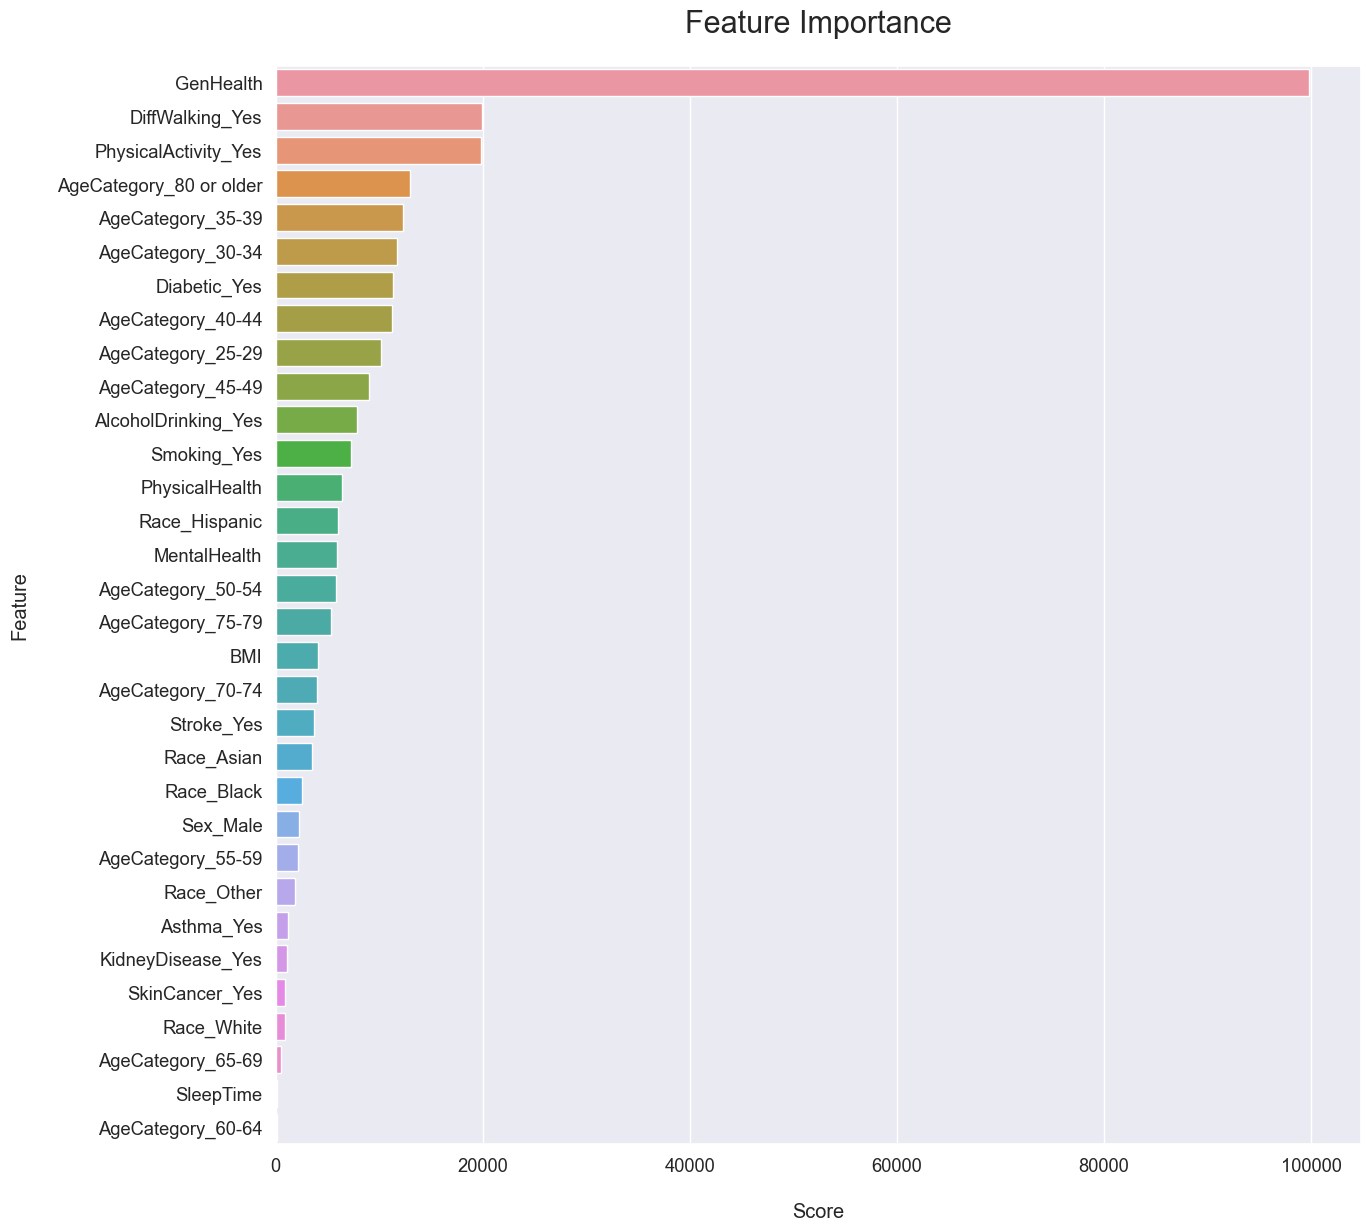

In [31]:
feature_selector = SelectKBest(f_classif).fit(X_train, y_train)

results = pd.DataFrame({
    "Score": feature_selector.scores_,
    "Feature": X_train.columns
}).sort_values(by="Score", ascending=False)

_, ax = plt.subplots(figsize=(14, 14))
p = sns.barplot(ax=ax, data=results, x="Score", y="Feature")
_ = p.set_title("Feature Importance")

Топ-3 наиболее важных признаков:
- GenHealth (оценка общего самочувствия)
- PhysicalActivity (физические нагрузки помимо работы)
- DiffWalking (сложности при ходьбе)
Так же видно, что большую роль играет возрастная группа, болезнь диабетом, курение и алкоголь

Самыми бесполезными признаками оказались:
- SleepTime (сколько часов в день спит респондент)
- Категории возрастов около 60 лет
- RaceWhite (раса белокожих людей)
- SkinCancer (рак кожи)
- Asthma (астма)
- KidneyDisease (заболевание почек)

Некоторые выводы мы получили ещё на этапе анализа данных

Давайте выбросим из датасета 7 бесполезных признаков (потому что 7 - счастливое число):

In [32]:
useless_features = results["Feature"][-7:]
X_train = X_train.drop(columns=useless_features)
X_test = X_test.drop(columns=useless_features)
useless_features

29           Asthma_Yes
30    KidneyDisease_Yes
31       SkinCancer_Yes
26           Race_White
18    AgeCategory_65-69
4             SleepTime
17    AgeCategory_60-64
Name: Feature, dtype: object

# 7. Моделирование

Применим несколько моделей из sklearn, посмотрим на плюсы и минусы и выберем кандидата для дальнейшего исследования

In [33]:
patch_sklearn()


def get_metrics(labels, predictions, predictions_proba):
    """
    Calculates several metrics.
    :param labels: ground truth labels.
    :param predictions: predicted labels.
    :param predictions_proba: predicted probabilities.
    :return: list of [accuracy, precision, recall, f1, AUC ROC]
    """
    return np.array([
        accuracy_score(labels, predictions),
        precision_score(labels, predictions),
        recall_score(labels, predictions),
        f1_score(labels, predictions),
        fbeta_score(labels, predictions, beta=2),
        roc_auc_score(labels, predictions_proba)
    ])


def evaluate_metrics(train: pd.DataFrame, target: pd.DataFrame, model, cv: int = 5, **kwargs) -> pd.DataFrame:
    """
    Perform cross-validation on training data and return computed metrics.
    :param train: training data.
    :param target: ground truth.
    :param model: fit-predict algorithm
    :param cv: number of folds in cross-validation
    :param kwargs: model named arguments
    :return: [accuracy, precision, recall, f1, AUC ROC] computed on train and validation data
    """
    train_metrics = np.zeros(6)
    valid_metrics = np.zeros(6)

    kf = KFold(n_splits=cv, shuffle=True, random_state=RAND_STATE)
    for train_index, valid_index in tqdm(kf.split(train, target), total=cv):
        train_data = train.iloc[train_index]
        train_labels = target.iloc[train_index]
        valid_data = train.iloc[valid_index]
        valid_labels = target.iloc[valid_index]

        fitted_model = model(**kwargs).fit(train_data, train_labels)

        train_prediction = fitted_model.predict(train_data)
        valid_prediction = fitted_model.predict(valid_data)

        train_prediction_proba = fitted_model.predict_proba(train_data)[::, 1]
        valid_prediction_proba = fitted_model.predict_proba(valid_data)[::, 1]

        train_metrics += get_metrics(train_labels, train_prediction, train_prediction_proba)
        valid_metrics += get_metrics(valid_labels, valid_prediction, valid_prediction_proba)

    train_metrics /= cv
    train_metrics = train_metrics.round(3)

    valid_metrics /= cv
    valid_metrics = valid_metrics.round(3)

    metrics = pd.DataFrame({
        "Type": ["Train", "Valid"],
        "Accuracy": [train_metrics[0], valid_metrics[0]],
        "Precision": [train_metrics[1], valid_metrics[1]],
        "Recall": [train_metrics[2], valid_metrics[2]],
        "F1 Score": [train_metrics[3], valid_metrics[3]],
        "F2 Score": [train_metrics[4], valid_metrics[4]],
        "AUC ROC": [train_metrics[5], valid_metrics[5]]
    })

    return metrics


def plot_metrics(metrics: pd.DataFrame, model_name: str = "") -> None:
    """
    Plot metrics.
    :param metrics: metrics received from evaluate_metrics method
    :param model_name: name of fitted model
    """
    metrics_to_plot = metrics.melt(id_vars="Type").rename(columns=str.title)
    _, ax = plt.subplots(figsize=(12, 9))
    p = sns.barplot(metrics_to_plot, ax=ax, x="Variable", y="Value", hue="Type")
    p.set_title(model_name)
    p.set_xlabel("Metric")
    p.bar_label(p.containers[0])
    p.bar_label(p.containers[1])
    p.set(ylim=(0, 1))
    sns.move_legend(p, "upper left", bbox_to_anchor=(1, 1))

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


KNN и SVM очень медленные модели и для такого большого датасета не подходят. Поэтому начнём с логистической регрессии

## 7.1. Логистическая регрессия

  0%|          | 0/5 [00:00<?, ?it/s]

CPU times: total: 5.12 s
Wall time: 3.19 s


,Type,Accuracy,Precision,Recall,F1 Score,F2 Score,AUC ROC
0,Train,0.786,0.763,0.831,0.796,0.817,0.864
1,Valid,0.786,0.763,0.831,0.796,0.817,0.864


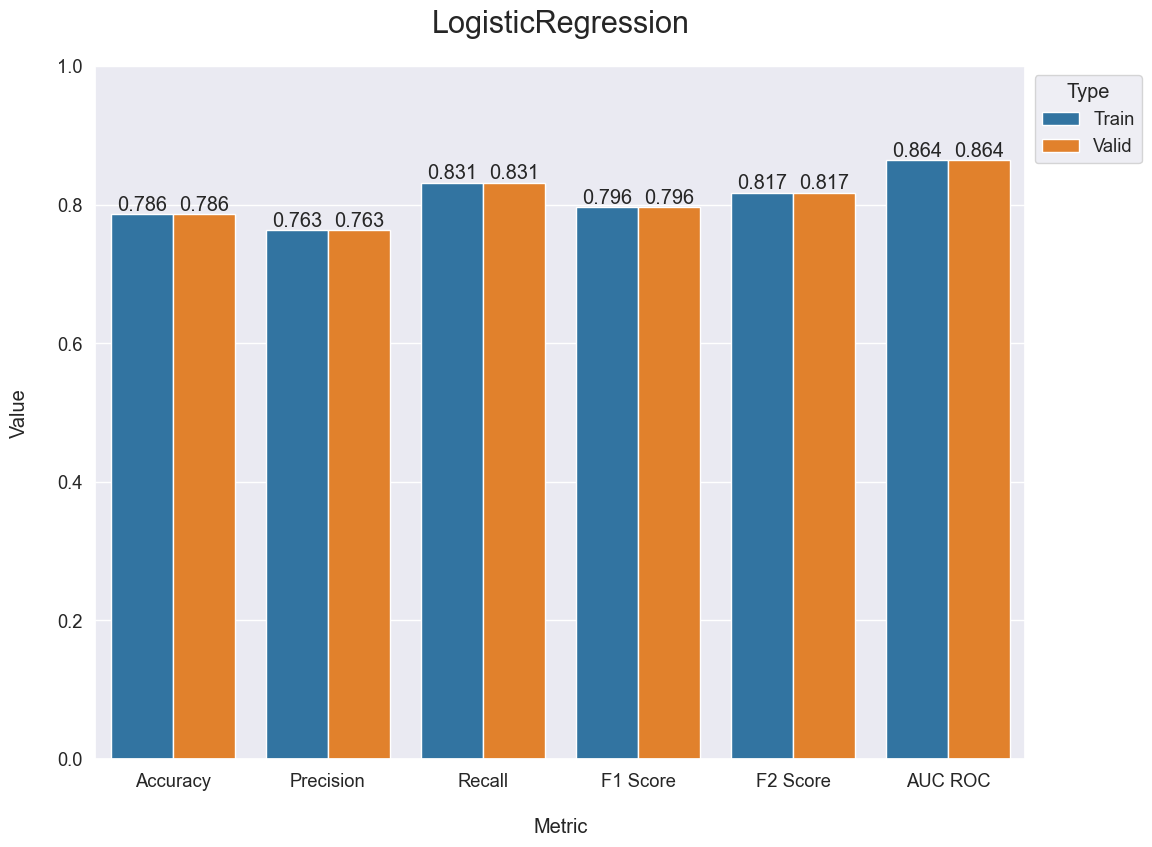

In [34]:
%%time
plot_metrics(logreg_metrics := evaluate_metrics(X_train, y_train, LogisticRegression), "LogisticRegression")
logreg_metrics

Простая логистическая регрессия удивительным образом одинаково отрабатывает и на обучающей, и на валидационной выборках. Даже не знаю, как такое получилось. Давайте посмотрим на другие классификаторы и сравним

## 7.2. Модели на основе деревьев

Модели на основе деревьев могут более сложно подстраиваться под данные

  0%|          | 0/5 [00:00<?, ?it/s]

CPU times: total: 10 s
Wall time: 10.1 s


,Type,Accuracy,Precision,Recall,F1 Score,F2 Score,AUC ROC
0,Train,0.989,0.994,0.984,0.989,0.986,1.000
1,Valid,0.842,0.848,0.835,0.841,0.837,0.848


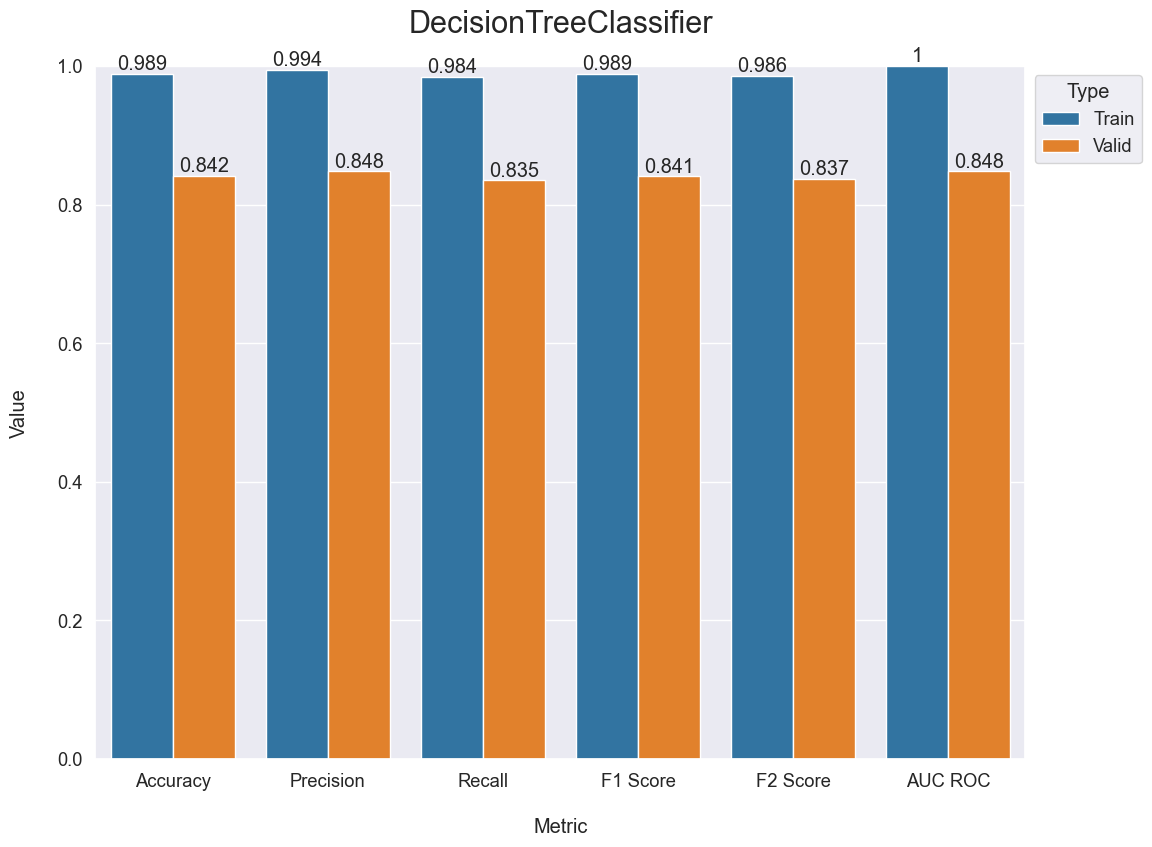

In [35]:
%%time
plot_metrics(
    dt_metrics := evaluate_metrics(X_train, y_train, DecisionTreeClassifier, random_state=RAND_STATE),
    "DecisionTreeClassifier"
)
dt_metrics

Решающее дерево крайне склонно к переобучению. На графике видно, что результаты на валидации значительно хуже, чем на трейне

  0%|          | 0/5 [00:00<?, ?it/s]

CPU times: total: 4min 8s
Wall time: 4min 8s


,Type,Accuracy,Precision,Recall,F1 Score,F2 Score,AUC ROC
0,Train,0.989,0.989,0.989,0.989,0.989,0.999
1,Valid,0.849,0.848,0.851,0.849,0.850,0.918


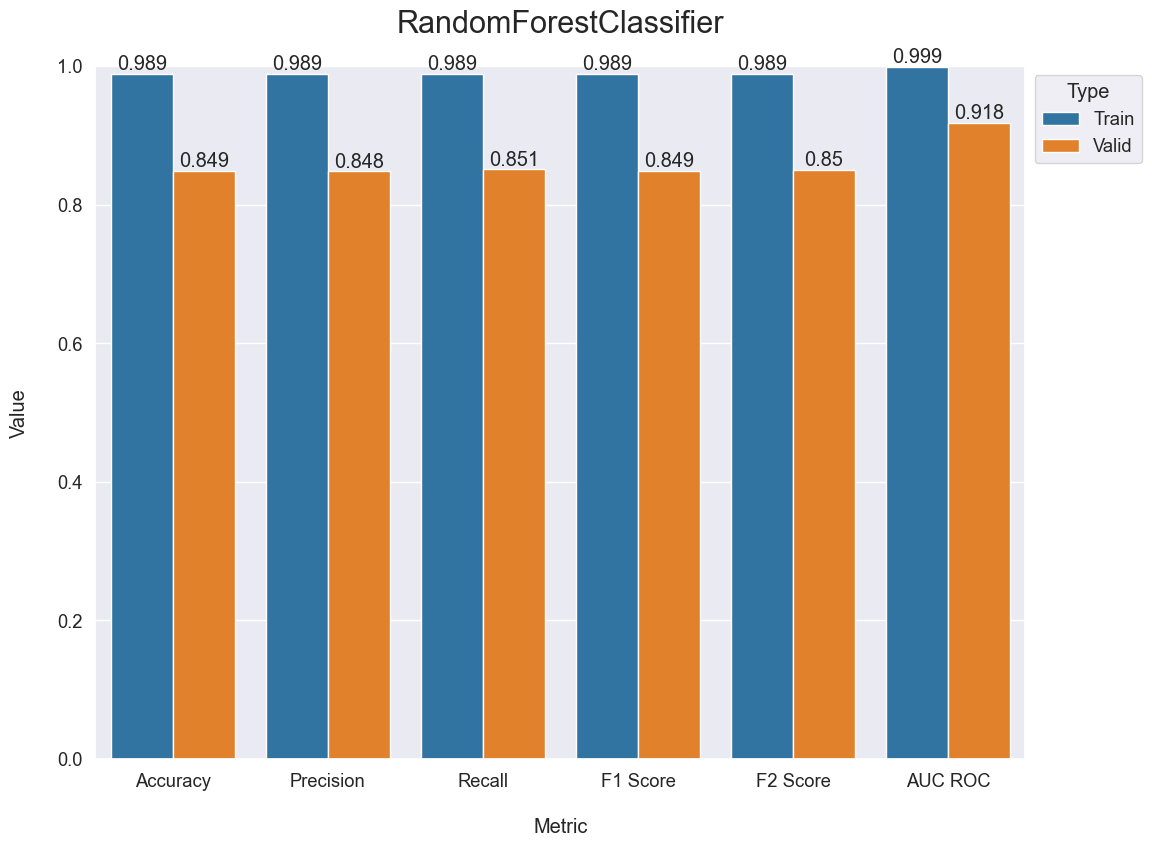

In [36]:
%%time
plot_metrics(
    rf_metrics := evaluate_metrics(X_train, y_train, RandomForestClassifier, n_estimators=100, random_state=RAND_STATE),
    "RandomForestClassifier"
)
rf_metrics

Примерно то же, что и с деревом решений: лес переобучился. Но при этом он показывает результаты гораздо лучше предшественников. В целом, потюнив параметры, вероятно эта модель будет неплохим решением

  0%|          | 0/5 [00:00<?, ?it/s]

CPU times: total: 4min 32s
Wall time: 4min 32s


,Type,Accuracy,Precision,Recall,F1 Score,F2 Score,AUC ROC
0,Train,0.989,0.994,0.984,0.989,0.986,1.000
1,Valid,0.848,0.848,0.849,0.848,0.849,0.905


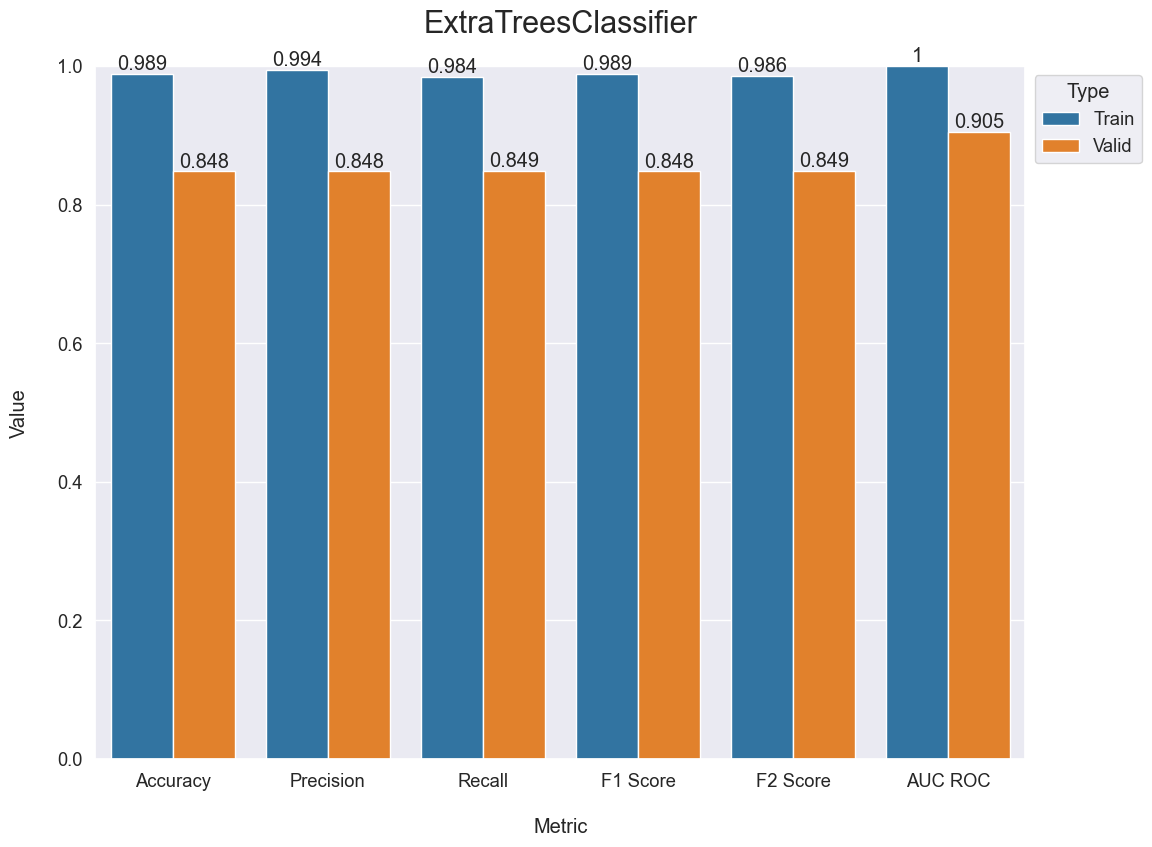

In [37]:
%%time
plot_metrics(
    et_metrics := evaluate_metrics(X_train, y_train, ExtraTreesClassifier, random_state=RAND_STATE),
    "ExtraTreesClassifier"
)
et_metrics

Мега рандомные деревья так же как и рандомный лес переобучается. Показывает себя в среднем чуть хуже, чем RF. И обучается в несколько раз дольше

  0%|          | 0/5 [00:00<?, ?it/s]

CPU times: total: 2min 14s
Wall time: 2min 14s


,Type,Accuracy,Precision,Recall,F1 Score,F2 Score,AUC ROC
0,Train,0.789,0.765,0.835,0.799,0.82,0.868
1,Valid,0.789,0.765,0.835,0.798,0.82,0.867


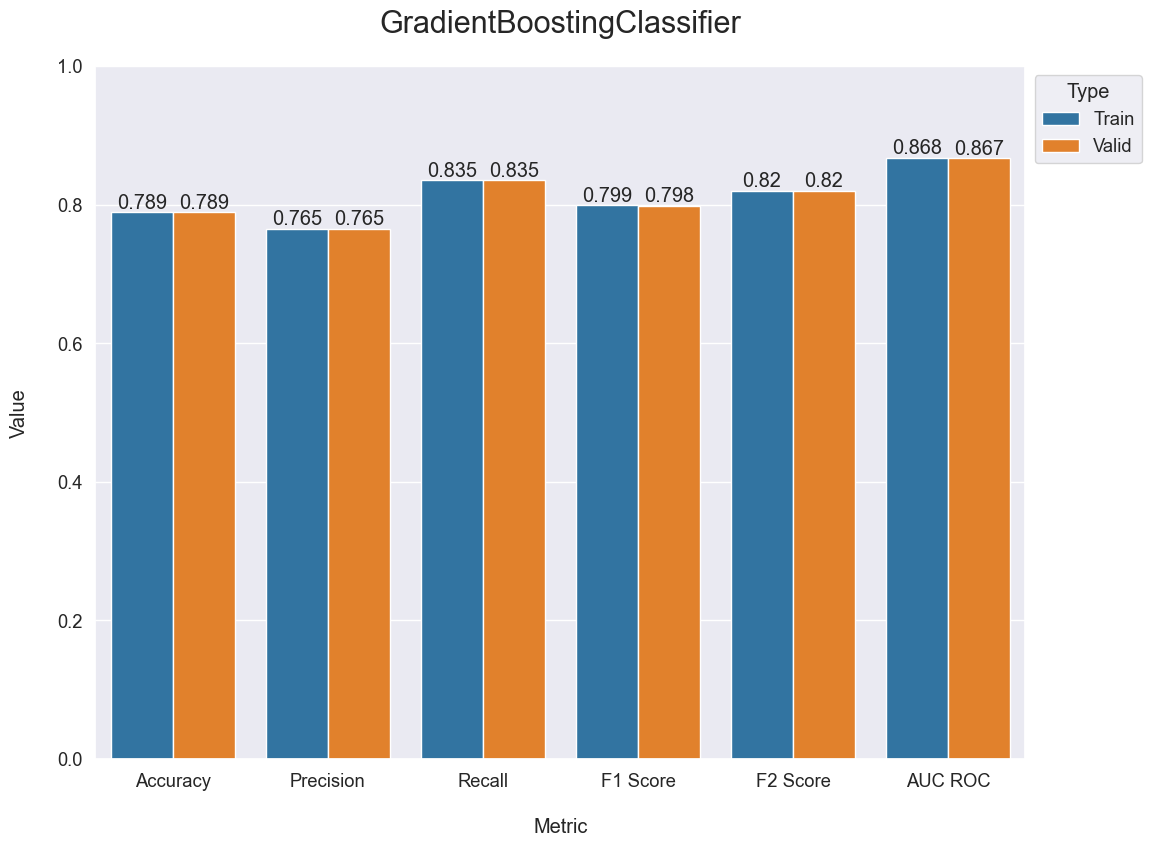

In [38]:
%%time
plot_metrics(
    gb_metrics := evaluate_metrics(X_train, y_train, GradientBoostingClassifier, random_state=RAND_STATE),
    "GradientBoostingClassifier"
)
gb_metrics

Как и логистическая регрессия, градиентный бустинг смог получить практически одинаковый результат и на трейне, и на валидации. Мега харош. GB сложно переобучить. В целом, модель наверняка даст неплохой результат и на тесте, но стоит отметить, что по качеству GB в текущем случае хуже RF

## 7.3. Хайповые модели

Рассмотрим модификации градиентного бустинга: LightGBM, XGBoost и CatBoost

  0%|          | 0/5 [00:00<?, ?it/s]

CPU times: total: 1min 23s
Wall time: 8.19 s


,Type,Accuracy,Precision,Recall,F1 Score,F2 Score,AUC ROC
0,Train,0.797,0.777,0.834,0.805,0.822,0.879
1,Valid,0.796,0.776,0.833,0.803,0.821,0.877


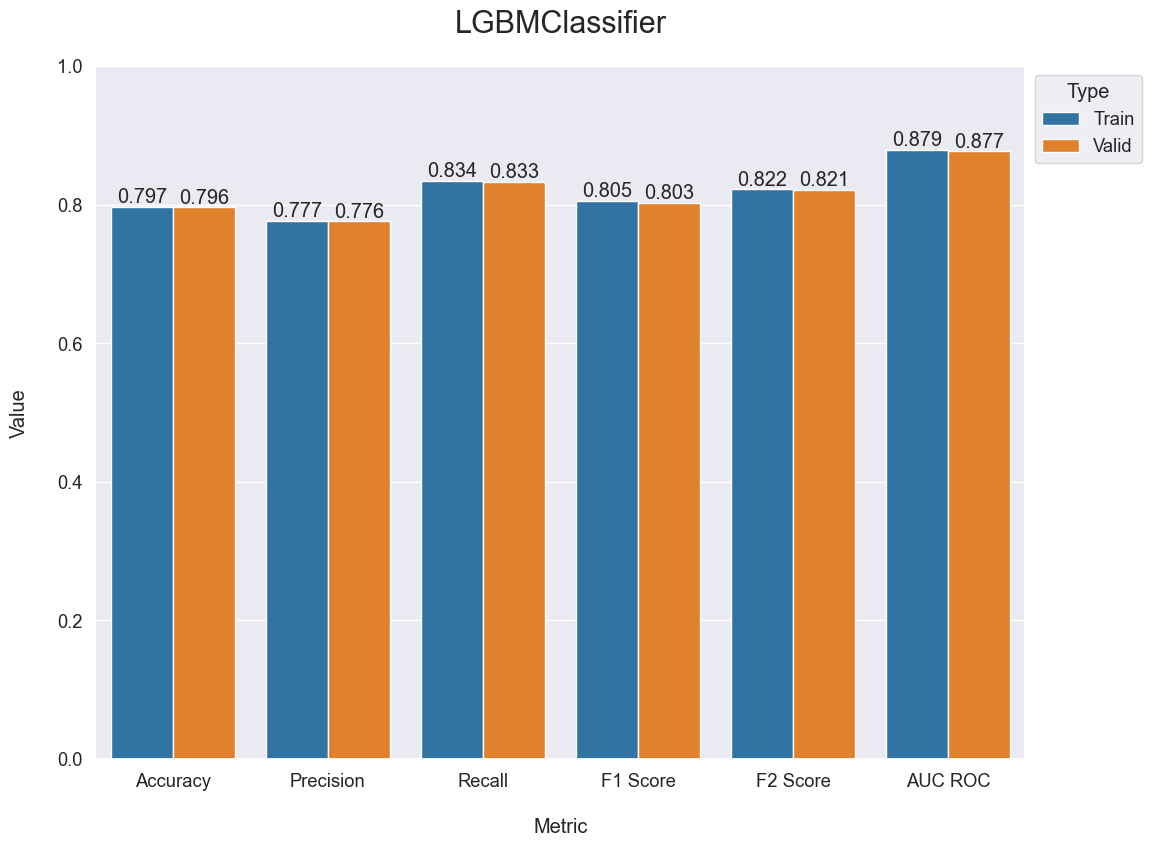

In [39]:
%%time
plot_metrics(
    lgb_metrics := evaluate_metrics(X_train, y_train, LGBMClassifier, random_state=RAND_STATE),
    "LGBMClassifier"
)
lgb_metrics

Тот же GB, но лучше и в десятки раз быстрее

  0%|          | 0/5 [00:00<?, ?it/s]

CPU times: total: 9min 2s
Wall time: 38.6 s


,Type,Accuracy,Precision,Recall,F1 Score,F2 Score,AUC ROC
0,Train,0.848,0.827,0.881,0.853,0.870,0.929
1,Valid,0.842,0.822,0.875,0.847,0.864,0.924


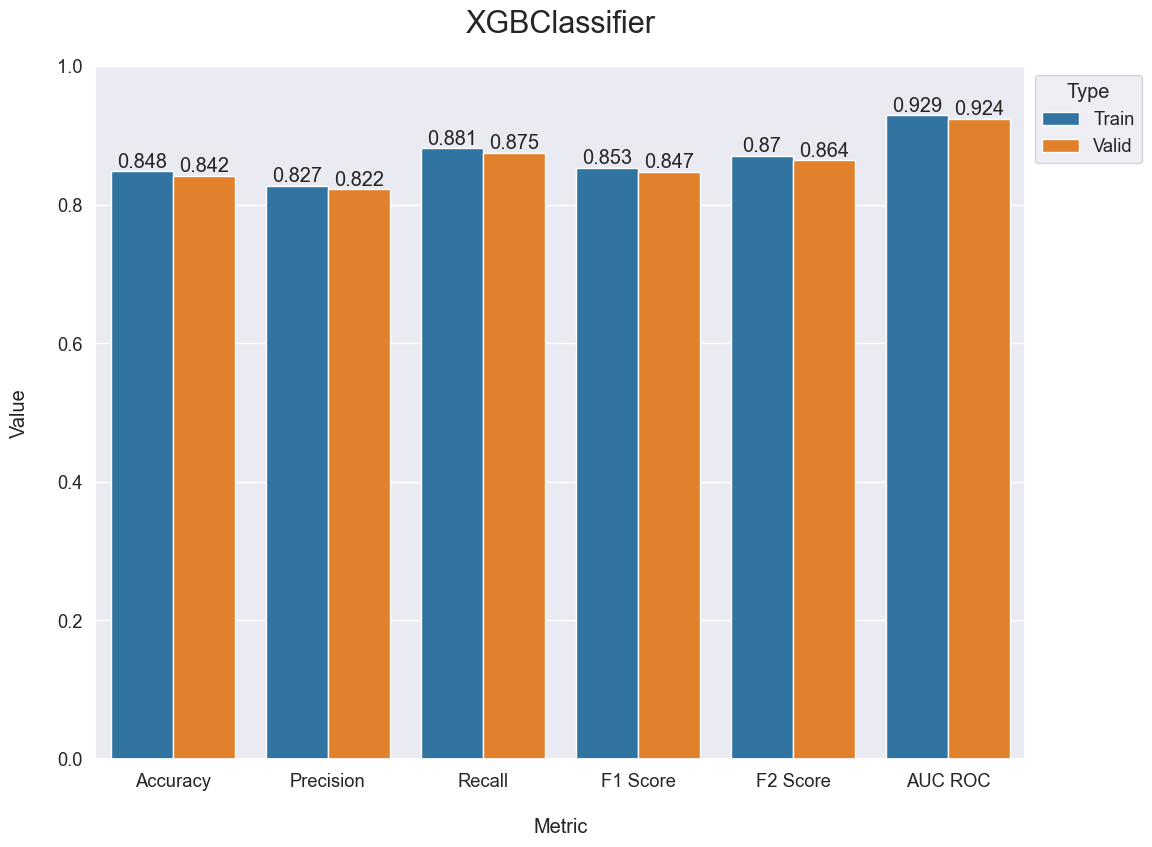

In [40]:
%%time
plot_metrics(
    xgb_metrics := evaluate_metrics(X_train, y_train, XGBClassifier, random_state=RAND_STATE),
    "XGBClassifier"
)
xgb_metrics

Немного лучше Light GB, но медленнее

  0%|          | 0/5 [00:00<?, ?it/s]

CPU times: total: 21min 6s
Wall time: 1min 44s


,Type,Accuracy,Precision,Recall,F1 Score,F2 Score,AUC ROC
0,Train,0.823,0.802,0.860,0.830,0.848,0.903
1,Valid,0.818,0.797,0.854,0.824,0.842,0.897


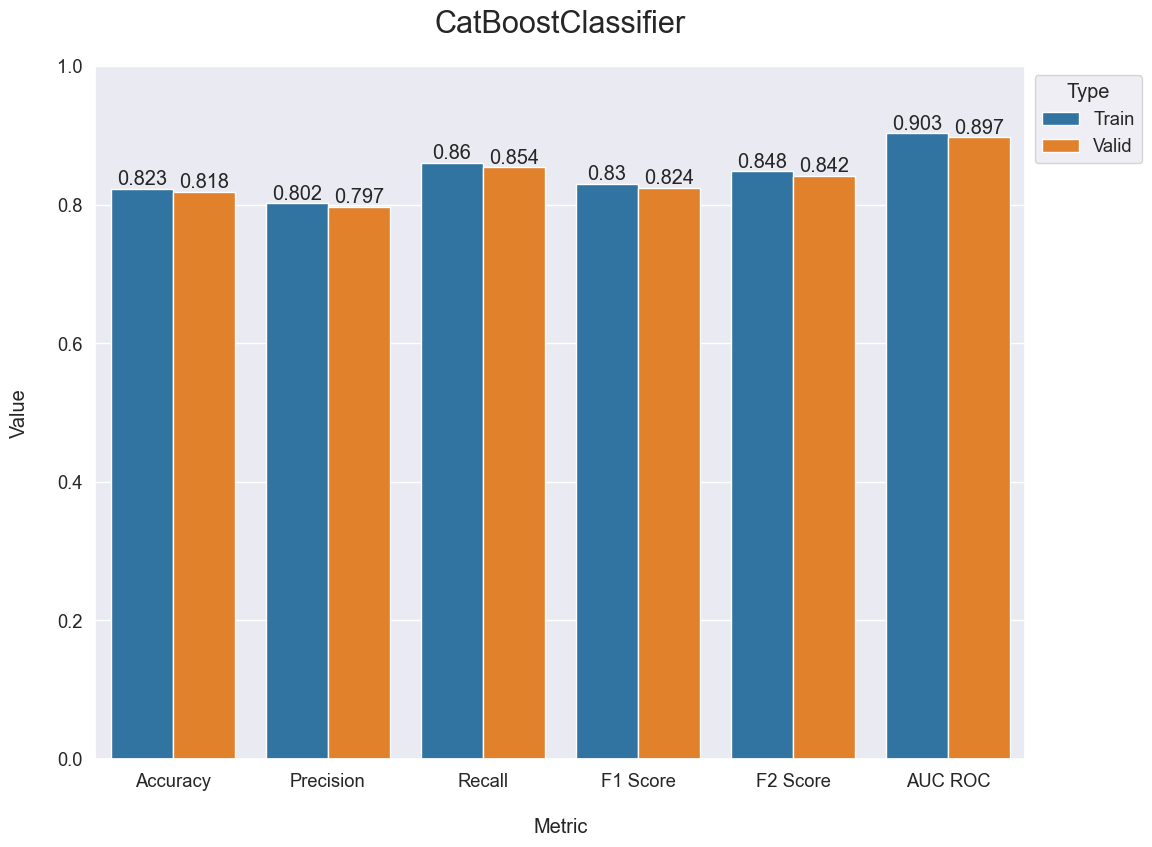

In [41]:
%%time
plot_metrics(
    cat_metrics := evaluate_metrics(X_train, y_train, CatBoostClassifier, random_state=RAND_STATE, verbose=False),
    "CatBoostClassifier"
)
cat_metrics

Результаты схожи с Extreme GB, но ещё медленнее

Составим сводную таблицу метрик по всем моделям на валидации и отсортируем по полноте:

In [42]:
pd.DataFrame(
    data=[
        logreg_metrics.loc[1], dt_metrics.loc[1], rf_metrics.loc[1],
        et_metrics.loc[1], gb_metrics.loc[1], lgb_metrics.loc[1], xgb_metrics.loc[1], cat_metrics.loc[1]
    ],
    index=["Logistic Regression", "Decision Tree", "Random Forest", "Extra Trees", "Gradient Boosting", "LGBM",
           "XGB", "CatBoost"]
).drop(columns=["Type"]).sort_values(by="Recall", ascending=False)

,Accuracy,Precision,Recall,F1 Score,F2 Score,AUC ROC
XGB,0.842,0.822,0.875,0.847,0.864,0.924
CatBoost,0.818,0.797,0.854,0.824,0.842,0.897
Random Forest,0.849,0.848,0.851,0.849,0.850,0.918
Extra Trees,0.848,0.848,0.849,0.848,0.849,0.905
Decision Tree,0.842,0.848,0.835,0.841,0.837,0.848
Gradient Boosting,0.789,0.765,0.835,0.798,0.820,0.867
LGBM,0.796,0.776,0.833,0.803,0.821,0.877
Logistic Regression,0.786,0.763,0.831,0.796,0.817,0.864


- XGB: классифицирует хорошо (даёт высокий AUC ROC), не переобучается и в целом большой молодец
- CatBoost: отстаёт на ~2% от XGB и работает дольше
- RF: несильно отстаёт от предшественников (и во многом даже превосходит), но переобучается
- ET: аналогично с RF, склонен к переобучению. Ещё и обучается долго
- DT: аналогично
- GB: сильно отстаёт по некоторым метрикам от предшественников, и гораздо медленнее XGB
- LGBM: по полноте такой же как и GB, но немного лучше по остальным метрикам. Главное преимущество - скорость
- LG: отстаёт по всем метрикам, но зато молниеносный

Overall, в текущей задаче стоит рассматривать устойчивые к переобучению модели (как минимум, у меня не очень много времени, чтобы вечность подстраивать параметры так, чтобы убить переобучение), с приличным качеством (LR и GB отлетают) и быстрые (тоже по причине времени). XGB, CatBoost крайне сильны, но перебирать параметры придётся долго. Поэтому я возьму на рассмотрение самый быстрый из модификаций GB: **LGBM**

# 8. Light GBM Classifier

Подберём параметры с помощью GridSearch

*P.S. можно было использовать [optuna](https://optuna.org/), но у меня возникли некоторые технические проблемы*

In [43]:
def plot_grid_results(grid_clf, x_ticks, param_name):
    """
    Draws a plot of the dependence of the parameter on the error
    :param grid_clf: GridSearchCV classifier
    :param x_ticks: x-axis labels
    :param param_name: which parameter did we go over
    """
    losses = -grid_clf.cv_results_["mean_test_score"]
    stds = grid_clf.cv_results_["std_test_score"]
    plt.plot(x_ticks, losses, 'r.-')
    plt.fill_between(x_ticks, losses - stds, losses + stds, alpha=0.15, facecolor="red")
    plt.grid()
    plt.xlabel(param_name)
    plt.ylabel("Log loss")
    plt.title(f"Dependence of error on {param_name}")

**Количество деревьев.** Чтобы модель не переобучалась, на всякий случай ограничим глубину:

In [44]:
%%time
n_estim_range = range(100, 1001, 100)
param = "n_estimators"

n_est_clf = GridSearchCV(LGBMClassifier(random_state=RAND_STATE, max_depth=7), param_grid={
    param: n_estim_range,
}, cv=5, scoring="neg_log_loss")
n_est_clf.fit(X_train, y_train)
n_est_clf.best_params_

CPU times: total: 30min 25s
Wall time: 2min 10s


{'n_estimators': 1000}

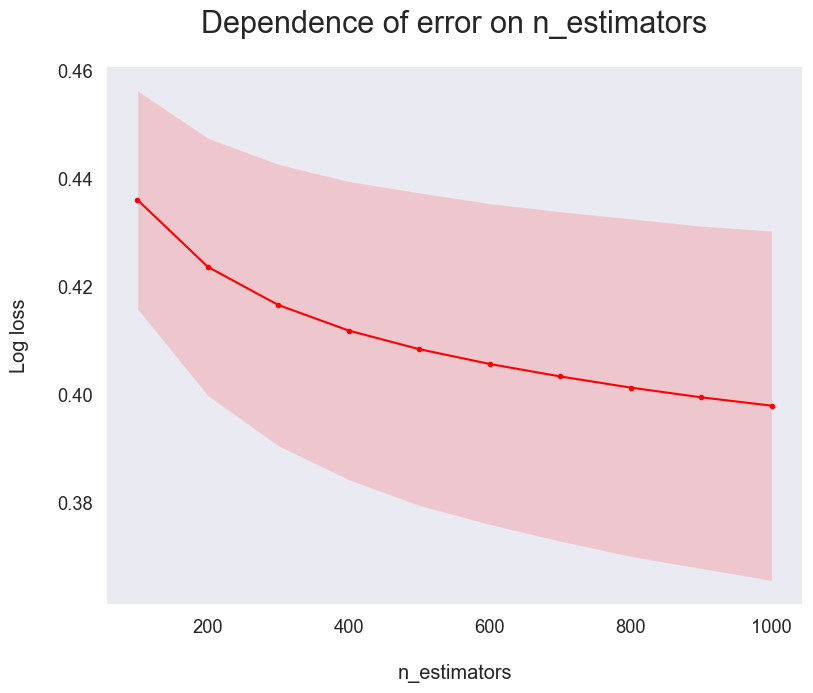

In [45]:
plot_grid_results(n_est_clf, n_estim_range, param)

Больше деревьев - лучше. Но падение ошибки незначительное, при этом очень большой разброс ошибки. Остановимся на 1000 деревьях

**Глубина деревьев.** Используем найденное количество деревьев с предыдущей итерации поиска:

In [46]:
%%time
max_depth_range = range(1, 24, 2)
param = "max_depth"

max_depth_clf = GridSearchCV(LGBMClassifier(**n_est_clf.best_params_, random_state=RAND_STATE), param_grid={
    param: max_depth_range,
}, cv=5, scoring="neg_log_loss")
max_depth_clf.fit(X_train, y_train)
max_depth_clf.best_params_

CPU times: total: 56min 54s
Wall time: 4min


{'max_depth': 19}

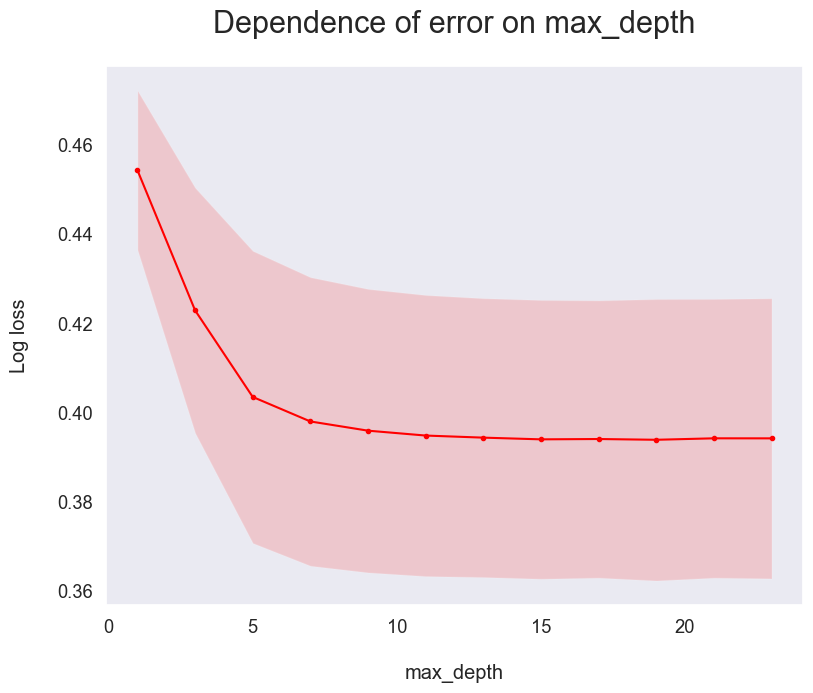

In [47]:
plot_grid_results(max_depth_clf, max_depth_range, param)

Примерно с `max_depth = 11` алгоритм сошёлся. При `max_depth = 19` ошибка оказалась чуть ниже, но на уровне погрешности. Дальше смотреть не имеет смысла

Обучим классификатор с полученными значениями параметров:

In [48]:
final_clf = LGBMClassifier(**n_est_clf.best_params_, **max_depth_clf.best_params_, random_state=RAND_STATE).fit(X_train,
                                                                                                                y_train)
pd.DataFrame(
    get_metrics(y_test, final_clf.predict(X_test), final_clf.predict_proba(X_test)[::, 1]),
    index=["Accuracy", "Precision", "Recall", "F1 Score", "F2 Score", "AUC ROC"], columns=["Score"]
)

,Score
Accuracy,0.761421
Precision,0.208800
Recall,0.631363
F1 Score,0.313817
F2 Score,0.449448
AUC ROC,0.778573


Стоит помнить, что тестовые данные всё ещё несбалансированные, поэтому accuracy не говорит о реальном качестве модели

Визуализируем матрицу ошибок:

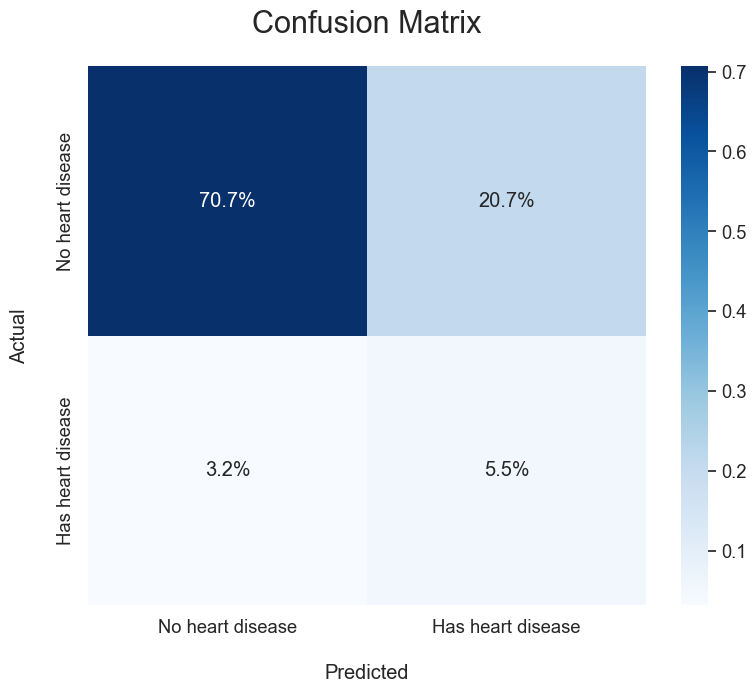

In [49]:
cm = confusion_matrix(y_test, final_clf.predict(X_test))
p = sns.heatmap(cm / cm.sum(), annot=True, cmap="Blues", fmt=".1%",
                xticklabels=["No heart disease", "Has heart disease"],
                yticklabels=["No heart disease", "Has heart disease"])
p.set_xlabel("Predicted")
p.set_ylabel("Actual")
_ = p.set_title("Confusion Matrix")

Таким образом, мы свели ошибку второго рода к минимуму (3.2%). Ошибка первого рода равна 20.7%

In [50]:
unpatch_sklearn()

# 9. Выводы


## 9.1. Что касается сердца

Что касается здоровья, то риск сердечных заболеваний возрастает многократно, если человек испытывает проблемы с ходьбой и подъёме по лестницам (возможно, отдышка). Стоит уделять больше времени спорту. Так же стоит проверить сердце, если у человек болен диабетом. Немалое влияние на сердце оказывают и курение с алкоголем. Основные группы людей с сердечными заболеваниями - люди в среднем возрасте (около 40 лет) и престарелые люди (80+ лет)

На работу сердца (что удивительно) не влияет режим сна. Не имеет значения раса, хотя у Испанцев есть некоторая тенденция к сердечным заболеваниям (непонятно, чем это обусловлено). Болезни почек, астма и рак кожи практически не влияют на работу сердца

В целом, если человек чувствует себя плохо и не знает причины, то это хороший повод проверить сердце, так как крупная часть респондентов, имеющих сердечное заболевание, отметили своё плохое самочувствие


## 9.2. Что касается модели


На основе данных признаков очень сложно точно предсказать наличие болезни сердца у человека (в оригинальном датасете признаков было около 300, в этом, сокращённом датасете, 18 признаков). Однако хорошо себя показали модели на основе ансамбля из деревьев, особенно градиентный бустинг. Тем не менее модель на основе LGBM получилась совсем неглупой, она способна давать логичные прогнозы. В данной работе мы максимизировали полноту, чтобы минимизировать вероятность ложно классифицировать больного человека, тем самым модель старается делать меньше критических ошибок, которые могут навредить здоровью пациентов
